### Import libraries

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import yfinance as yf
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox  
from arch import arch_model
import statsmodels.api as sm
import matplotlib.pyplot as plt



### Initial data

In [21]:
ticker = "MSFT"
# download day per day microsoft stock
data = yf.download(ticker, interval="1d", period="10y")
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2015-04-09,35.800282,35.921111,35.601775,35.601775,25723900
2015-04-10,36.007423,36.205930,35.739869,35.929747,28022000
2015-04-13,36.041950,36.300875,35.722614,35.731247,30276700
2015-04-14,35.947014,36.274979,35.722613,36.076473,24244400
2015-04-15,36.473480,36.646096,35.972899,36.041944,27343600


In [22]:
data.shape

(2516, 5)

In [23]:
n= len(data)
P_train = data.iloc[:int(n*0.8)][("Open", "MSFT")]
P_test = data.iloc[int(n*0.8):][("Open", "MSFT")]
P_train.shape

(2012,)

C:\Users\Clara G\AppData\Local\Temp\ipykernel_1636\712555607.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


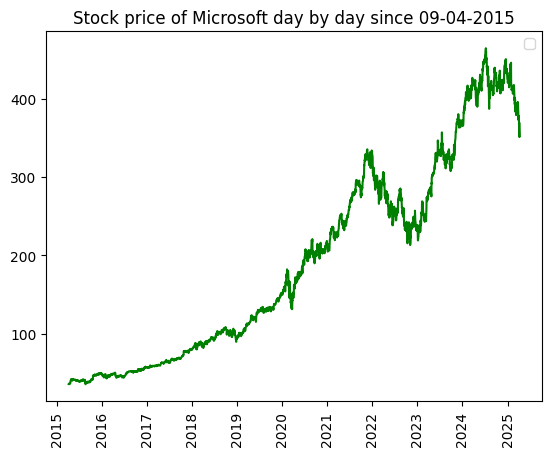

In [24]:
plt.plot(np.array(data.index), data[("Open", "MSFT")].values, c="green")
plt.xticks(rotation=90)
plt.legend()
plt.title("Stock price of Microsoft day by day since 09-04-2015")
plt.show()

### Removing the trend and making it stationnary: returns

We observe a high level of variability in recent years and very little in the earlier years. To stabilize this difference in variability, we will take the logarithm of the prices.

C:\Users\Clara G\AppData\Local\Temp\ipykernel_1636\3258140383.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


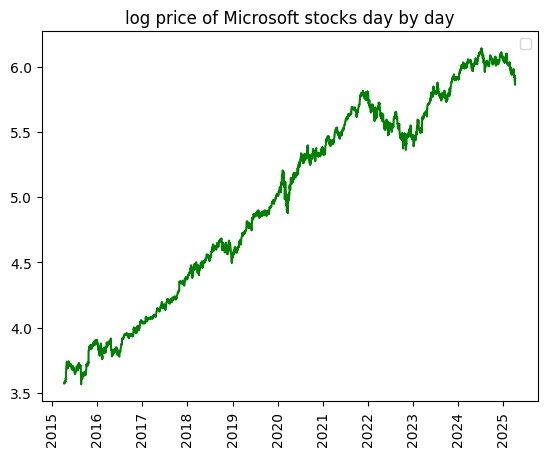

In [25]:
plt.plot(np.array(data.index), np.log(data[("Open", "MSFT")].values), c="green")
plt.xticks(rotation=90)
plt.legend()
plt.title("log price of Microsoft stocks day by day")
plt.show()

Text(0.5, 1.0, 'ACF h=100')

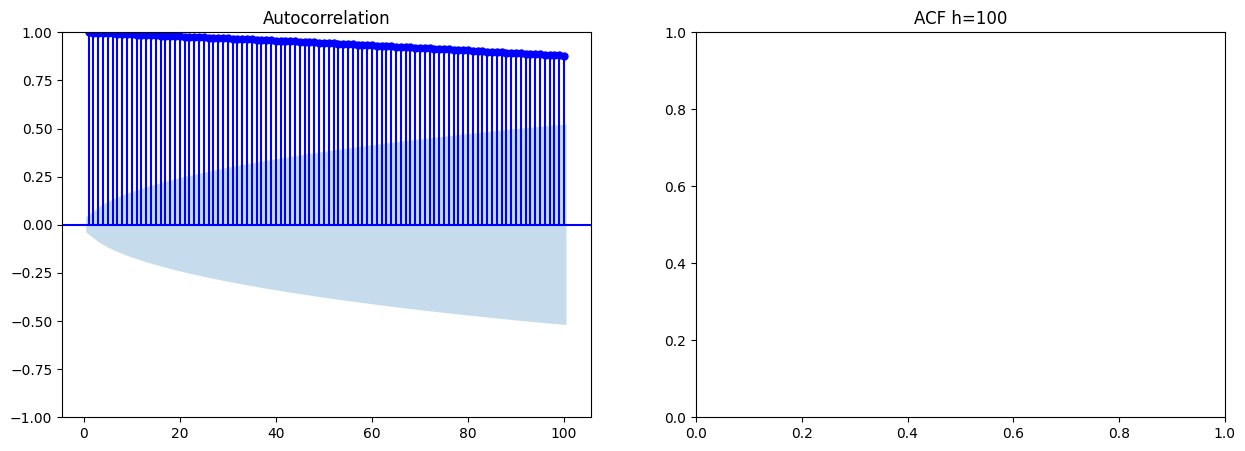

In [ ]:
plt.figure(figsize=(15, 5))
plot_acf(data[("Open", "MSFT")].values, alpha=.05, lags=100, zero=False, color="blue", 
         vlines_kwargs={'colors': 'blue'})
plt.title("ACF h=100")


However, if we examine the autocorrelograms of this series, we observe non-stationarity up to at least lag 200.

We use the lag operator to achieve stationarity because it is convenient, but also because these differences have a meaningful interpretation in finance: they represent returns, which are of interest to investors.
$$
\log(P_t) - \log(P_{t-1})
$$
are called *log return* or *returns*.
where:  
- \( P_t \) is the price of the asset at time \( t \),  
- \( P_{t-1} \) is the price of the asset in the previous period.  

**Interpretation:**  
This logarithmic return is an approximation of the **simple return** when it is small:  

$$
r_t \approx \frac{P_t - P_{t-1}}{P_{t-1}}
$$  

We observe a significant spike in 2020—the day COVID was announced—the price dropped, as seen in the graph.  


When multiplied by 100, we can directly obtain information in percentage terms. For example: "In April 2020, it dropped by 15%." 

We easily see the **volatility clustering** meaning that periods of high volatility (where returns, whether positive or negative, have large amplitudes) tend to cluster together over time. In other words, if we observe large fluctuations today, there is a high likelihood that this trend will continue for several days (or periods) before returning to a calmer phase.

**Why it doesn’t make much sense to look at the ACF at a very large lag (e.g., 300) on a series with 2500 points?**

When calculating the autocorrelation at **lag \( k \)**, we compare pairs \( (x_t, x_{t-k}) \) for \( t = k+1 \) to \( T \). Therefore, only \( T - k \) observations remain to estimate the correlation.

The estimation becomes increasingly **noisy** as \( k \) increases.

The confidence bands (usually \( \pm \frac{2}{\sqrt{T}} \)) rely on asymptotic approximations.

But as \( k \) increases, we have fewer data points to estimate, so:
- **The approximation becomes worse**,
- and the intervals become **less reliable**.

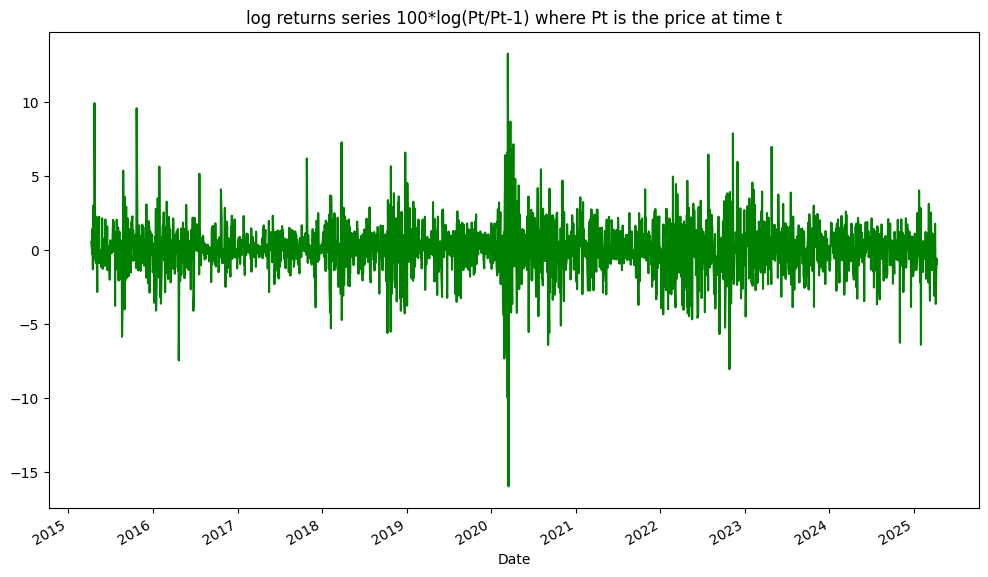

In [27]:
# Log-difference to stationarize the series
plt.figure(figsize=(12,7))
Xt = 100*np.log(data[("Close", ticker)]).diff().dropna()
Xt.plot(c="green")
plt.title("log returns series 100*log(Pt/Pt-1) where Pt is the price at time t")
plt.show()

### Statistical and Distributional Analysis of returns

In [28]:
Xt.describe()

count    2515.000000
mean        0.091170
std         1.705174
min       -15.945321
25%        -0.689719
50%         0.095809
75%         0.972124
max        13.292912
Name: (Close, MSFT), dtype: float64

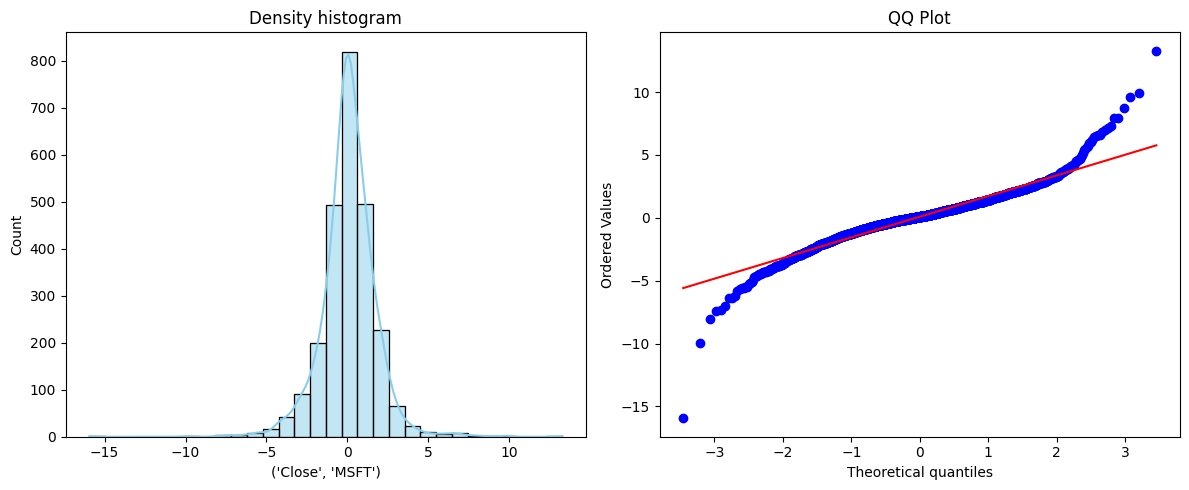

Kurtosis coefficient of Xt: 7.8255


In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Density histogram
sns.histplot(Xt, kde=True, bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Density histogram')

# QQ Plot
stats.probplot(Xt, dist="norm", plot=axes[1])
axes[1].set_title('QQ Plot')

plt.tight_layout()
plt.show()

# Calculate kurtosis coefficient
kurtosis_Xt = stats.kurtosis(Xt, fisher=True)  # Fisher=True gives the value-3 so then compare to 0

print(f"Kurtosis coefficient of Xt: {kurtosis_Xt:.4f}") 

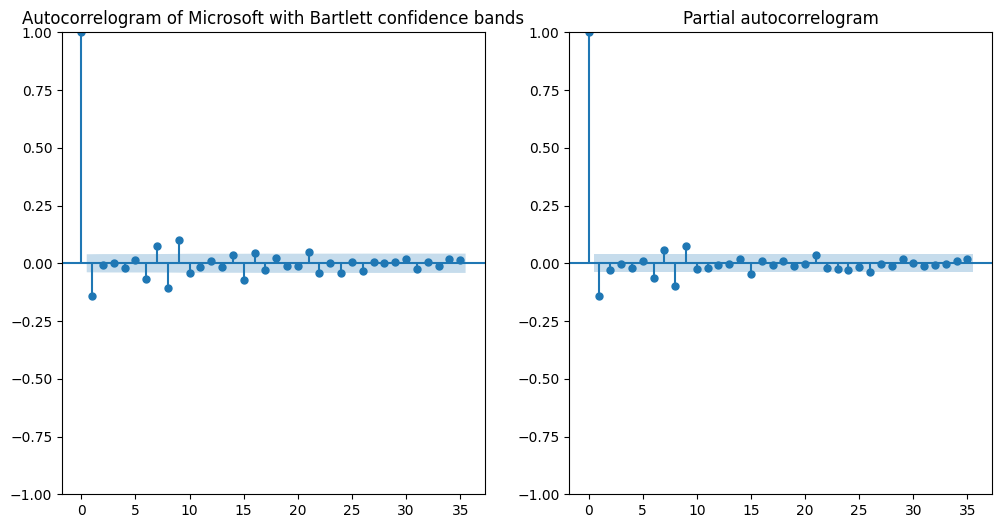

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(Xt, alpha=.05, ax= axes[0])
axes[0].set_title("Autocorrelogram of Microsoft with Bartlett confidence bands")
plot_pacf(Xt, alpha=.05, ax=axes[1])
axes[1].set_title("Partial autocorrelogram")
plt.show()

In the first graph and with the description of Xt, it can be observed that returns fluctuate around zero.

We've ploted the density and the QQPlot of Xt to analyse our series. We observe that the tails contain more data than expected under a Gaussian distribution. Heavy tails indicate that returns exhibit higher kurtosis than a Gaussian distribution. We're not surprised since in finance large price jumps (shocks, crises, or bubbles) occur more frequently than not. The QQ plot reveals that the quantiles of our series do not align with the theoretical quantiles of a normal distribution.

The kurtosis coefficient measures how "sharp" or "flat" a variable's distribution is compared to a normal distribution. Fisher=True gives the (value - 3) so then we are comparing the result to 0.

- if the result close to 0, the distribution is similar to a Normal distribution
- if the result > 0, distribution with fat tails
- if the result > 0, distribution with light tails

Here, the Kurtosis coefficient of Xt: 7.8531 so clearly Xt has fat tails. 

**All that proves that the empirical distribution deviates from normality**

#### --> 1st stylized fact: The distribution of returns is not normal but peak center, fat tails and almost symetric

The autocorrelation graph also shows the sample autocorrelations of the returns, which, in general, are not significant and, in any case, have a very small magnitude.

#### --> 2nd stylized fact: There is almost no correlation between returns for different days



### Model decision

We recognize an MA(1) process because only the first autocorrelation is significant. We can also see that some covariances at lags h = 6, 7, 8, 9 fall outside the confidence bands, but that's expected since we are working with real data and the confidence interval is at 95%, meaning that naturally 5 out of 100 values may fall outside by chance.

One could also consider an MA(9).

Since the ACF doesn’t have just a single value outside the confidence bands, we might also consider fitting an AR(1).

An AR(9) could also be a possibility based on the partial autocorrelation plot, as only the first 9 PACF values fall outside the confidence bands—again, keeping in mind the potential error due to the confidence interval.


### FIT 


In [31]:
# Compute log returns
train_returns = 100*np.log(P_train).diff().dropna()
test_returns = 100*np.log(P_test).diff().dropna()

#### Fitting an MA(1) model

$$
y_{t} = \mu + \epsilon_{t} + \theta \epsilon_{t-1}
$$

**Returns forecasts**: MA models the conditional expectation

**Parameters** it estimates:

μ (mean) . Here = 0

θ (moving average coefficient)

sigma2 white noise varianc


In [32]:
# Fit MA(1) for returns 
ma1 = ARIMA(train_returns, order=(0, 0, 1))
results = ma1.fit()
# Results
print("\n=== Estimation results for an MA(1) ===")
print(results.summary())

residuals = results.resid 
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_test)


c:\Users\Clara G\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Clara G\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Clara G\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== Estimation results for an MA(1) ===
                               SARIMAX Results                                
Dep. Variable:       ('Open', 'MSFT')   No. Observations:                 2011
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -3880.781
Date:                Wed, 09 Apr 2025   AIC                           7767.563
Time:                        11:00:49   BIC                           7784.382
Sample:                             0   HQIC                          7773.736
                               - 2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1030      0.035      2.971      0.003       0.035       0.171
ma.L1         -0.0908      0.016     -5.628      0.000      -0.122      -0.059
sigma2     

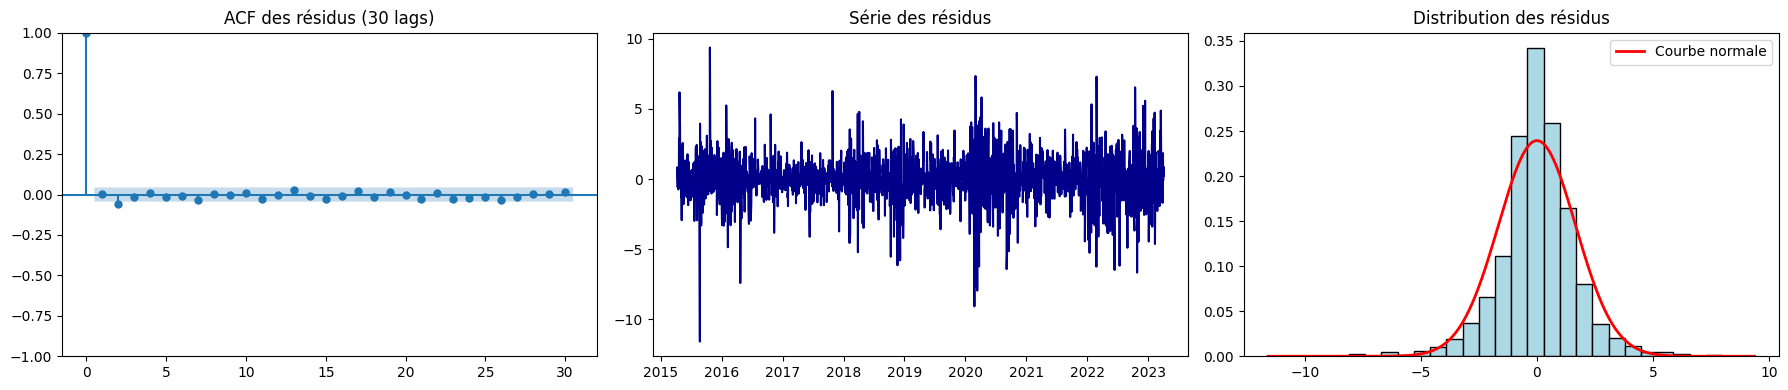

In [33]:
from scipy.stats import norm
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
sm.graphics.tsa.plot_acf(results.resid, lags=30, ax=ax1, title="ACF des résidus (30 lags)")
ax2.plot(results.resid, c="darkblue"); ax2.set_title("Série des résidus")
# Histogram + Normal distribution
resid = results.resid
mean = np.mean(resid)
std = np.std(resid)

# Histogram
ax3.hist(resid, bins=30, density=True, color="lightblue", edgecolor="black")

# Normal distribution curve to comparew to the residuals distribution
x = np.linspace(min(resid), max(resid), 1000)
ax3.plot(x, norm.pdf(x, mean, std), 'r-', lw=2, label='Courbe normale')

ax3.set_title("Distribution des résidus")
ax3.legend()
plt.tight_layout(); plt.show()


 **\( P_t \)** the price series, **\( X_t \)** defined by :

$$ X_t = \log(P_t) - \log(P_{t-1}) $$


We observe in the correlation plot that at lag h = 1, the correlation is -0.15, and according to the formula from the course:

$$ \rho(1) = - 0.15 \Rightarrow - 0.15 = \frac{\theta}{1 + \theta^2} $$

Solving this equation :

$$ \theta_1  \approx -0.154 $$

$$ \theta_2   \approx -6.513 $$

$$
\text{As } \left| \theta_1 \right| < 1 \text{ and } \left| \theta_2 \right| > 1,  
\text{ we maintain } \theta = -0.154 \text{ because this guarantees the invertibility of the MA(1) process.}
$$
However, the value estimated by the MA(1) model is -0.09, same sign and not very far from -0.15. Seems correct.

##### The ACF of the residuals

All the values for the ACF of residuals are inside the confidence bands. We conclude that everithing has been well estimated and the model fits the data.

##### The Ljung-Box test

The Ljung-Box test is a statistical test used to evaluate if there is significant autocorrelation in the residuals of a model. In other words, it is used to determine whether there are patterns not captured by the model that could indicate that the model does not fit the data properly. 

The null hypothesis (𝐻₀) of the test is that there is no autocorrelation in the residuals.

The alternative hypothesis (𝐻₁) is that there is autocorrelation in the residuals.

Here the Ljung-Box test has a p-value of 0.46>0.05 using 10 lags and a p-value of 0.98 using 1 lag(in the summary) so we might think the model fits well our data and we don't reject the null hypotheses: there's no autocorrelation in the residuals. However, this test assumes that there is constant variance.(~~)

##### The Jarque-Bera test

It is used to assess whether a data sample follows a normal distribution. The Jarque-Bera test focuses on the characteristics of the **data distribution**, especially its skewness and kurtosis.

Null hypothesis (𝐻₀): The data follows a normal distribution (i.e., the skewness and kurtosis are the same as in a normal distribution).

Alternative hypothesis (𝐻₁): The data does not follow a normal distribution (i.e., the skewness or kurtosis differ from those of a normal distribution).

In our case, the JB test has a very high value 1579.73 with a p-value of 0.00. Furthermore, we have Heteroskedasticity of 1.74 and kurtosis of 7.28 >0 so we clearly reject null hypothesis: our data **does not follow a normal distribution.**


#### Fitting an AR(9)

In [34]:
# Fit an AR(9) model to the train_returns series
ar9 = ARIMA(train_returns, order=(9, 0, 0))
results = ar9.fit()

# Results
print("\n=== Estimation results for an AR(9) ===")
print("\n=== Résultats des estimations pour un AR(9) ===")
print(results.summary())

residuals = results.resid 
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_test)


c:\Users\Clara G\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Clara G\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Clara G\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== Estimation results for an AR(9) ===

=== Résultats des estimations pour un AR(9) ===
                               SARIMAX Results                                
Dep. Variable:       ('Open', 'MSFT')   No. Observations:                 2011
Model:                 ARIMA(9, 0, 0)   Log Likelihood               -3875.888
Date:                Wed, 09 Apr 2025   AIC                           7773.776
Time:                        11:00:56   BIC                           7835.447
Sample:                             0   HQIC                          7796.414
                               - 2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1029      0.032      3.245      0.001       0.041       0.165
ar.L1         -0.0861      0.017     -5.1

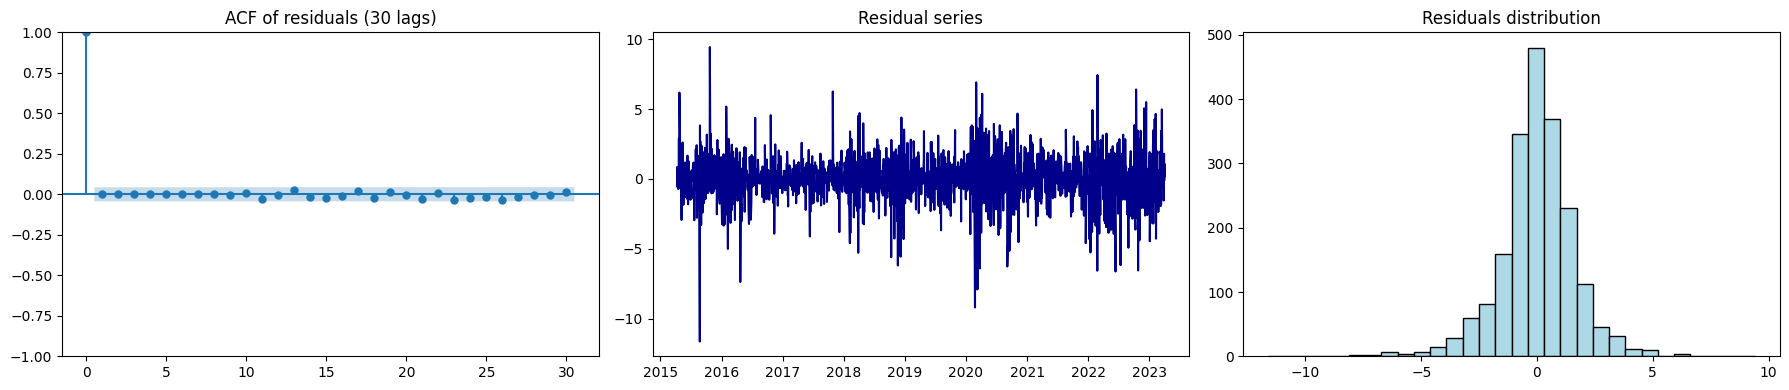

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
sm.graphics.tsa.plot_acf(results.resid, lags=30, ax=ax1, title="ACF of residuals (30 lags)")
ax2.plot(results.resid, c="darkblue"); ax2.set_title("Residual series")
ax3.hist(results.resid, bins=30, color="lightblue", edgecolor="black"); ax3.set_title("Residuals distribution")
plt.tight_layout(); plt.show()

#### Fit un ARMA(6,2)

In [36]:
# Fit an ARMA(6,2) model to the train_returns series
arma_62 = ARIMA(train_returns, order=(6, 0, 2))
results = arma_62.fit()

# Results
print("\n=== Estimation results for an ARMA(6,2)===")
print(results.summary())

c:\Users\Clara G\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Clara G\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Clara G\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== Estimation results for an ARMA(6,2)===
                               SARIMAX Results                                
Dep. Variable:       ('Open', 'MSFT')   No. Observations:                 2011
Model:                 ARIMA(6, 0, 2)   Log Likelihood               -3874.869
Date:                Wed, 09 Apr 2025   AIC                           7769.738
Time:                        11:01:08   BIC                           7825.802
Sample:                             0   HQIC                          7790.318
                               - 2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1008      0.025      4.065      0.000       0.052       0.149
ar.L1          0.0848      0.335      0.253      0.800      -0.572       0.742
ar.L2   

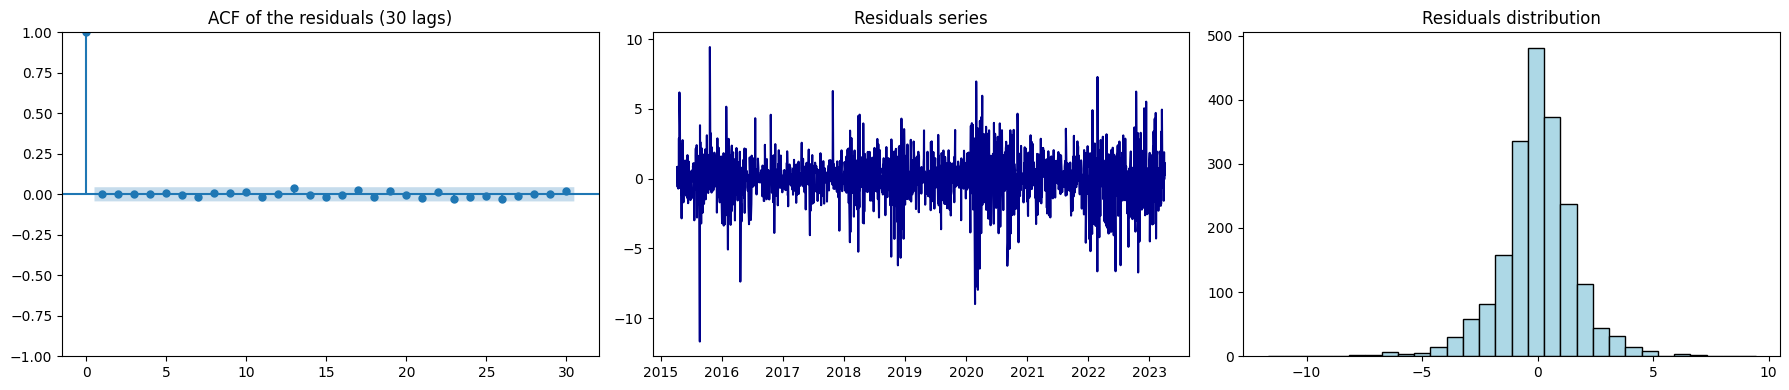

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
sm.graphics.tsa.plot_acf(results.resid, lags=30, ax=ax1, title="ACF of the residuals (30 lags)")
ax2.plot(results.resid, c="darkblue"); ax2.set_title("Residuals series")
ax3.hist(results.resid, bins=30, color="lightblue", edgecolor="black"); ax3.set_title("Residuals distribution")
plt.tight_layout(); plt.show()


De plus, l'hypothèse nulle avec laquelle les bornes de l'IC sont calculées considère un bruit blanc fort, ce qui n'est probablement pas le cas vu la nature de nos données donc on n'est pas choquées des résultats, ça correspond bien à un MA(1).

On voit que la covariance entre Xt et Xt-1 (h=1) est négative parce que que le rendement de l'action hier soit positif veut pas dire que celui d'aujourd'hui va l'être aussi. Résultat cohérent aussi.

Mais cela nous semble bizarre parce que ça peut pas être si simple de devenir riche.

### Diebold confidence bounds --> estimate variance

Under H₀: {corr(h) = 0}, the null hypothesis of no correlation, for i.i.d. variables, the distribution of the empirical autocorrelation is Normal(0, 1/T). But when there is heteroskedasticity, the asymptotic variance under H₀ is no longer 1/T, but larger.

We therefore assume that the variables are not i.i.d., meaning the variance of returns changes over time (heteroskedasticity).

The Diebold-corrected confidence bounds formula is given by:

$$ \text{Confidence Bound} = Var(r_x(\tau)) = \frac{1}{T} \left( 1 + \frac{\hat{\gamma}_{x^2}(\tau)}{\hat{\sigma}_x^4} \right)
$$

Where:  

- $$ \hat{\gamma}_{x^2}(k) \text{ is the empirical covariance of order k of the squared returns.}$$  
- $$\hat{\sigma}_x \text{ is the empirical standard deviation of the returns. }$$ 
- $$\ T \text{ is the sample size}


 

In [38]:
T = Xt.shape[0]
Yt = Xt - np.mean(Xt)  # Daily log-returns removing the mean 
var_Y2 = np.var(Yt**2) # sample variance of squared demeaned returns

# Calcul de l'autocorrélation des rendements au carré (avec 50 décalages)
rhoy2 = acf(Yt**2, nlags=50, fft=True)  # 51x1 vector (inclut le lag 0)
rhoy2 = rhoy2[1:]  # On ne garde pas le lag 0

lags = np.arange(1, 51)  # Crée un array des lags [1, 2, ..., 50]

cov_Y2 = var_Y2 * rhoy2  # 50x1 vector: sample AutoCovariances of squared demeaned returns
gamma0 = np.var(Yt)      # sample variance of demeaned returns

DB = 1.96 * np.sqrt((1 + (cov_Y2 / gamma0**2)) / T)  # 30x1: Diebold-corrected 95% confidence bands

In [39]:
len(DB)

50

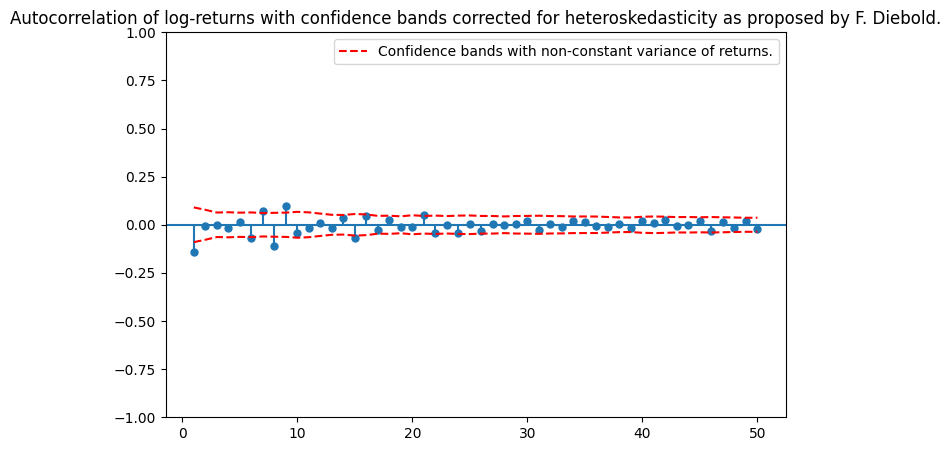

In [40]:
#autocorrelation
fig, ax = plt.subplots(figsize=(8, 5))
plot_acf(Xt, lags=50, alpha=None, ax=ax, zero=False,
          title='Autocorrelation of log-returns with confidence bands corrected for heteroskedasticity as proposed by F. Diebold.')

#bandes de confiance
x_vals = np.arange(1, len(lags) + 1)  
ax.plot(x_vals, DB, linestyle='dashed', color='red', label='Confidence bands with non-constant variance of returns.')
ax.plot(x_vals, -DB, linestyle='dashed', color='red')

ax.legend()
plt.show()

### Autocorrelation of Transformed Returns

Note that, since the expectation is zero, the squared and absolute returns are related to the dispersion/risk/variance. Thus, a positive correlation of these transformations means that volatility exhibits temporal dependence and will therefore appear clustered.

We will show that transformations of returns (Xt) can have significant autocorrelation even though returns themselves have a small autocorrelation. This is evident from two things:
- **Non-linear dependence**: The absence of correlation in the log-returns themselves (*Xₜ*) means that, on average, there is no linear relationship between past and future values of the series. However, the correlation of squared log-returns indicates that there is structure in the series, but this structure is non-linear. Indeed, standard time series models like ARMA models only capture linear dependencies. But here, the presence of correlation in the squares suggests that the variance of *Xₜ* depends on the past, which is typical of ARCH (*Autoregressive Conditional Heteroskedasticity*) and GARCH (*Generalized ARCH*) processes. These models explain how volatility evolves over time based on past returns realizations.

- **Daily returns are not produced by an i.i.d. process**: If *rₜ* were i.i.d., then any function of *rₜ* (including *rₜ²*) should also be uncorrelated with its past values. We see the dependence of volatility.

**Why Absolute Values and Not Raw Returns?**

Raw returns \( r_t \) typically have a mean close to zero, and positive and negative fluctuations tend to cancel each other out when calculating the standard autocorrelation. As a result, even though information about volatility (the size of the fluctuations) is present, it doesn’t show up in the autocorrelation function (ACF) of \( r_t \).

On the other hand, when we take the **absolute values** \( |r_t| \) (or the squares \( r_t^2 \)), we explicitly capture the magnitude of the movements, regardless of their direction. The autocorrelation of \( |r_t| \) is then defined by:

$$
\rho(k) = \frac{E\left[\left(|r_t| - \mu\right)\left(|r_{t+k}| - \mu\right)\right]}{\sigma^2}
$$

where \( \mu = E(|r_t|) \) and \( \sigma^2 \) is the variance of \( |r_t| \).

In a series showing volatility clustering, we tend to observe:

$$
E(|r_t| \, |r_{t+k}|) > E(|r_t|)^2 \quad \text{for several lags } k,
$$

which results in positive autocorrelation. This means that a large absolute value today increases the likelihood of having a large absolute value tomorrow, regardless of whether the return is positive or negative.



**The Role of the ACF of Absolute Values**

The ACF of absolute values thus tells us:

- **Volatility clustering**: High autocorrelation at multiple lags indicates that volatility tends to persist, meaning that <font color="orange">if the market is highly volatile today, it is likely to remain volatile tomorrow.
- <font color="white">**Dynamics of volatility shocks**: It can also help detect models like ARCH/GARCH, which specifically model this persistence in conditional variance.




<Figure size 1200x700 with 0 Axes>

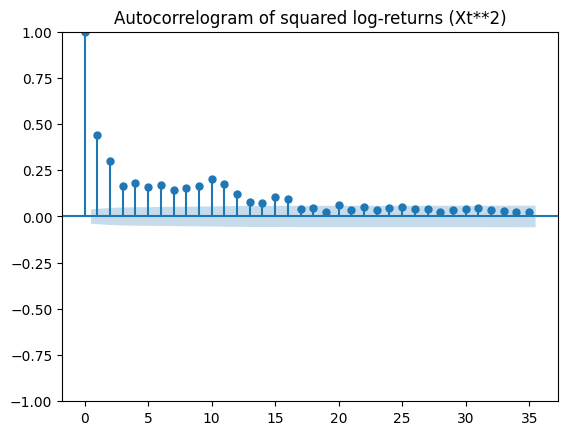

<Figure size 1200x700 with 0 Axes>

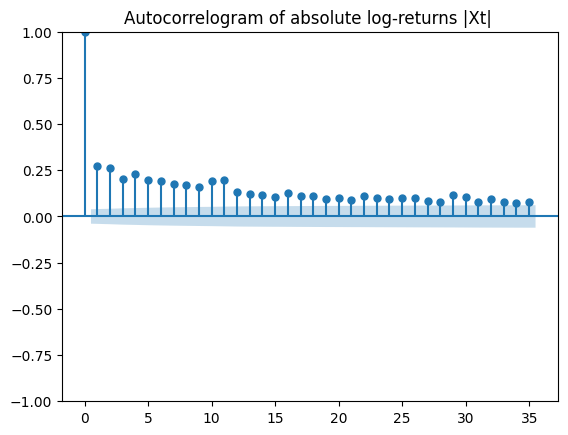

In [41]:
plt.figure(figsize=(12,7))
Xt_sqr = (np.log(data[("Close", ticker)]).diff().dropna() )**2
plot_acf(Xt_sqr, alpha=.05)
plt.title("Autocorrelogram of squared log-returns (Xt**2)")
plt.show()
plt.figure(figsize=(12,7))
Xt_sqr = np.absolute(np.log(data[("Close", ticker)]).diff().dropna() )
plot_acf(Xt_sqr, alpha=.05)
plt.title("Autocorrelogram of absolute log-returns |Xt| ")
plt.show()

### Conclusions

A linear model is not sufficient for a series with such volatility clustering.

The model that will explain the dependence of returns must be nonlinear and capable of explaining the 3 stylized facts.

### Fitting a GARCH model

Clearly the model that will explain the dependance between returns must explain all this and take into acount the volatility. Further exploring: GARCH models.

### **Bonus**
Pour le calcul théorique de theta du MA(1) on montre qu'il est cohérent avec le fait que la série des log(Xt) - log(Xt-2) est un MA(2)

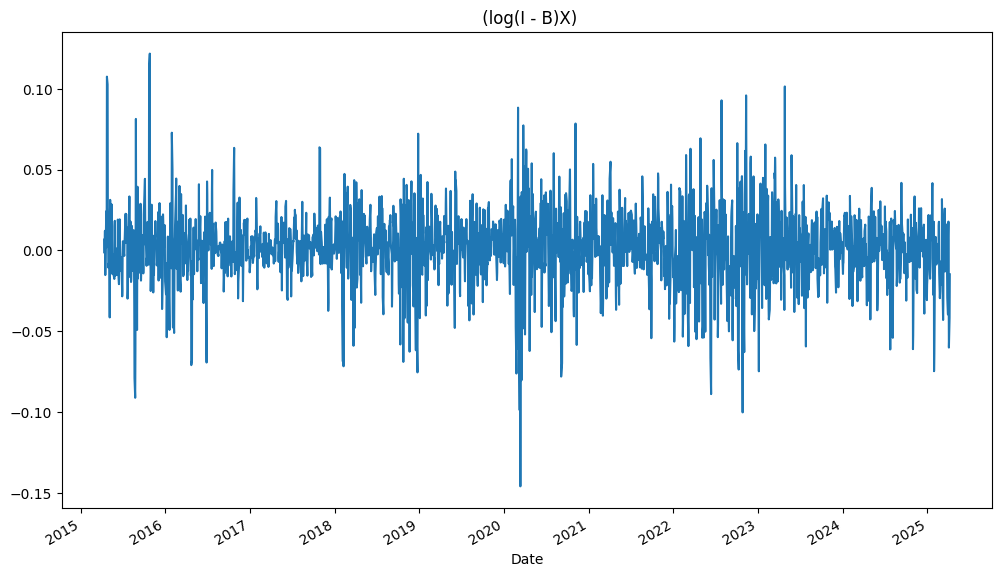

In [42]:
# Log-difference to stationarize the series
plt.figure(figsize=(12,7))
Yt = np.log(data[("Close", ticker)]).diff(2).dropna()
Yt.plot()
plt.title(" (log(I - B)X)")
plt.show()


**\( Y_t \)** la série des différences de **\( X_t \)** définie par :

$$ Y_t = \log(P_t) - \log(P_{t-2}) $$
$$Y_t = \log(P_t) - \log(P_{t-1}) +  \log(P_{t-1}) - \log(P_{t-2}) $$
$$ Y_t = X_t + X_{t-1} $$

On suppose que **\( X_t \)** suit un processus MA(1) :

$$ X_t = Z_t - \theta Z_{t-1} $$

où **\( Z_t \)** est un bruit blanc. En remplaçant cette expression dans **\( Y_t \)** :

$$ Y_t = (Z_t - \theta Z_{t-1}) + (Z_{t-1} - \theta Z_{t-2}) $$

$$ Y_t = Z_t - \theta Z_{t-1} + Z_{t-1} - \theta Z_{t-2} $$

$$ Y_t = Z_t + (1 - \theta) Z_{t-1} - \theta Z_{t-2} $$

On reconnaît ici un **MA(2)** avec :

$$ \theta_1 = 1 - \theta $$

$$ \theta_2 = -\theta $$


Ainsi, pour le processus MA(2) :

$$ \theta_1 = 1 - (-0.154) = 1.154 $$

$$ \theta_2 = -(-0.154) = 0.154 $$

Pour **\( \rho(2) \)**, nous utilisons la formule :

$$ \rho(2) = \frac{-\theta_2}{1 + \theta_1^2 + \theta_2^2} $$

$$ \rho(2) = \frac{-0.154}{2.356} $$

$$ \rho(2) \approx -0.065  $$ 
-0.065 semble être la valeur pour h=2 du graphique

Le modèle **MA(2)** de **\( Y_t \)** est donc :

$$ Y_t = Z_t + 1.154 Z_{t-1} + 0.154 Z_{t-2} $$

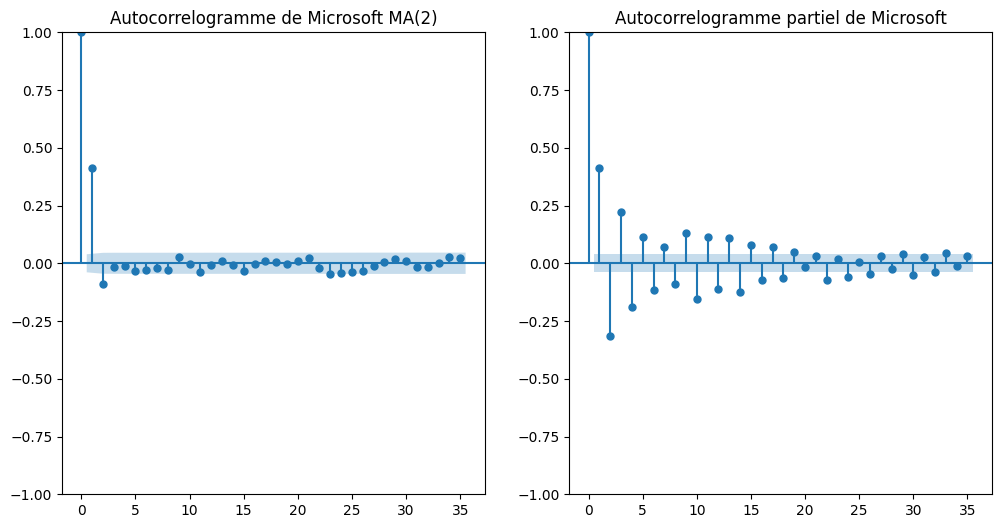

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(Yt, alpha=.05, ax= axes[0])
axes[0].set_title("Autocorrelogramme de Microsoft MA(2)")
plot_pacf(Yt, alpha=.05, ax=axes[1])
axes[1].set_title("Autocorrelogramme partiel de Microsoft")
plt.show()